In [1]:
import glob
import numpy as np
import math
import cv2
from cv2 import aruco
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pprint as pp

In [2]:
def getVectorFromDic(idx0,idx1):
    return marker_dict[idx0]["tvec"] - marker_dict[idx1]["tvec"]

def getPositionFromDic(idx0):
    return marker_dict[idx0]["tvec"]

# idx0: origin
def getAngleFromDic(idx1,idx0,idx2):
    return getAngle(getVectorFromDic(idx2,idx0),getVectorFromDic(idx1,idx0))

def getDistanceFromDic(idx0,idx1):
     return np.linalg.norm(getVectorFromDic(idx0,idx1))
    
def getJointVec(arr,joint_num):
    return np.array(arr[joint_num*4:joint_num*4+3])

def normalization(vec):
    return vec/np.linalg.norm(vec)

def getSize(vec):
    return np.linalg.norm(vec)

def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def getAngle(v1, v2):
    return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))

def vec_norm(vec):
    return vec/np.linalg.norm(vec)

def getUpVectorFromRvecs(idx):
    rtx = cv2.Rodrigues(rvecs[idx])[0]
    return rtx.T[2]

# Get Camera Parameters

In [3]:
parameter_dir=r"C:\Users\ZAIO\dev\python_aruco_marker_visualization\camera_parameters"

#load xml file
camera_parameters = {}
# camera_idxs = ["18284509","18284511","18284512"]
camera_idxs = ["18284509"]

parameter_types = ["CameraMatrix","Intrinsics","Distortion"]


for camera_idx in camera_idxs:
    fileToLoad = os.path.join(parameter_dir,camera_idx+".xml")
    fs = cv2.FileStorage(fileToLoad, cv2.FILE_STORAGE_READ)
    _camera_parameter = {}
    for parameter_type in parameter_types:
        _camera_parameter[parameter_type] = fs.getNode(parameter_type).mat()
        camera_parameters[camera_idx] = _camera_parameter

#3d points to image (2nd image)
extri = [0]*3
intri  = [0]*3
dist = [0]*3

for i in range(len(camera_idxs)):
    rotation_matrix = camera_parameters[camera_idxs[i]][parameter_types[0]][:,0:3]
    rvec,_ = cv2.Rodrigues(rotation_matrix)
    tvec = camera_parameters[camera_idxs[i]][parameter_types[0]][:,3]
    
    extri[i] = camera_parameters[camera_idxs[i]][parameter_types[0]]
    intri[i] = camera_parameters[camera_idxs[i]][parameter_types[1]]
    dist[i] = camera_parameters[camera_idxs[i]][parameter_types[2]]
    
camera_index = 0

mtx = camera_parameters[camera_idxs[camera_index]][parameter_types[1]]
dist = camera_parameters[camera_idxs[camera_index]][parameter_types[2]]
pp.pprint(mtx)
pp.pprint(dist)

array([[1.59106837e+03, 0.00000000e+00, 6.34909755e+02],
       [0.00000000e+00, 1.59838858e+03, 5.01707782e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
array([[ 1.36945721e-02],
       [-1.94217874e-01],
       [ 2.42371839e-04],
       [ 6.03200809e-04],
       [-4.39915075e+00],
       [ 3.17459364e-03],
       [-3.13005525e-01],
       [-3.73922900e+00]])


In [4]:
#Using 30 selected images
# json_data = {}
# with open(r"C:\Users\ZAIO\dev\opencv\samples\python\data.json") as json_file:
#     json_data = json.load(json_file)
#     pp.pprint(json_data)
    
# pp.pprint(json_data['camera_matrix'])
# pp.pprint(json_data['dist_coeff'])
    
# mtx = np.array(json_data['camera_matrix'])
# dist = np.array(json_data['dist_coeff'])

In [5]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
length_of_axis = 0.09
markerLength = 0.18


image_data = r"I:\20200730_mutliplearcuo\000000000000_rendered.png"
frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)


for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)



# Marker data to dictionary
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    _vecs["corner"] = corners[idx][0]
    marker_dict[marker_index] = _vecs
print("tvecs and rvecs for each marker\n")
# pp.pprint(marker_dict)



tvecs and rvecs for each marker



In [6]:
from scipy.spatial import distance
p1 = [1, 2, 3]
p2 = [4, 5, 6]
d = distance.euclidean(p1, p2)
print(d)

5.196152422706632


In [7]:
print(distance.euclidean(marker_dict[0]["tvec"],marker_dict[1]["tvec"]))
print(distance.euclidean(marker_dict[1]["tvec"],marker_dict[2]["tvec"]))
print(distance.euclidean(marker_dict[2]["tvec"],marker_dict[3]["tvec"]))
print(distance.euclidean(marker_dict[3]["tvec"],marker_dict[4]["tvec"]))

0.2711067329113772
0.1593690759221671
0.18307808559298833
0.18297988708830462


In [8]:
# def annotateDistanceFromDic(idx0,idx1):

def getCenterOnImageFromDic(idx):
    return np.average(marker_dict[idx]["corner"],axis = 0)

In [9]:
# def annotateDistanceFromDic(idx0,idx1):

def getCenterOnImageFromDic(idx):
    return np.average(marker_dict[idx]["corner"],axis = 0)


In [13]:
imagefiles = glob.glob(r'I:\20200806_picture\*.png')

In [14]:
 for image_data in imagefiles:
    image_data = image_data

    aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
    length_of_axis = 0.09
    markerLength = 0.18
    frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

    rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
    imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

    if(len(rvecs)>0):
        for i in range(len(rvecs)):
            imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)



        # Marker data to dictionary
        marker_dict = {}

        for idx,marker_index in enumerate(ids):
            marker_index = marker_index[0]
            _vecs = {}
            _vecs["rvec"] = rvecs[idx][0]
            _vecs["tvec"] = tvecs[idx][0]
            _vecs["corner"] = corners[idx][0]
            marker_dict[marker_index] = _vecs
        print("tvecs and rvecs for each marker\n")
        # pp.pprint(marker_dict)


        plt.figure()
        plt.figure(figsize=(15,15))

        for idx0,idx1 in [[0,1],[1,2]]:
            cen_x, cen_y = np.average([getCenterOnImageFromDic(idx0),getCenterOnImageFromDic(idx1)],axis = 0)
            distance = getDistanceFromDic(idx0,idx1)
            text = plt.text(int(cen_x), int(cen_y), "{:.3f}m".format(distance), fontsize=9,color = "red")
            text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

        plt.imshow(imaxis)
        plt.show()

TypeError: object of type 'NoneType' has no len()

In [24]:
image_data = r"I:\20200806_picture\000000000032_rendered.png"

# ARUCO_MIP_36h12
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
print(aruco_dict)
length_of_axis = 0.09
markerLength = 0.18
frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
print(frame.shape)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)



# Marker data to dictionary
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    _vecs["corner"] = corners[idx][0]
    marker_dict[marker_index] = _vecs
print("tvecs and rvecs for each marker\n")
# pp.pprint(marker_dict)

print(imaxis.shape)
plt.figure()
plt.figure(figsize=(15,15))

print(ids)

for idx0,idx1 in [[0,1],[1,2]]:
    cen_x, cen_y = np.average([getCenterOnImageFromDic(idx0),getCenterOnImageFromDic(idx1)],axis = 0)
    distance = getDistanceFromDic(idx0,idx1)
    text = plt.text(int(cen_x), int(cen_y), "{:.3f}m".format(distance), fontsize=9,color = "red")
    text.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

plt.imshow(imaxis)
plt.show()

<aruco_Dictionary 000001C0DDB4EEB0>
(1024, 1280, 3)


TypeError: object of type 'NoneType' has no len()

In [26]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
pp.pprint(aruco_dict)

<aruco_Dictionary 000001C0DE2AD5F0>


In [45]:
def upVectorFromDic(idx0,idx1,idx2):
    vec = np.cross(getVectorFromDic(idx0,idx1),getVectorFromDic(idx2,idx1))
    return  vec/np.linalg.norm(vec)

In [46]:
#floor_up_vector_average (Using marker rvec)
floor_idx = [4,5,6,7]
data = []
for i in floor_idx:
    data.append(getUpVectorFromRvecs(i))
floor_up_vector_average = np.average(np.array(data),axis=0)

#floor_up_vector_cross
vec = [upVectorFromDic(6,5,4),upVectorFromDic(7,6,5),upVectorFromDic(4,7,6),upVectorFromDic(5,4,7)]
floor_up_vector_cross = vec_norm(np.average(np.array(vec),axis=0))

In [47]:
##Experiment01
floor_up_vector_average = [-0.06778487, -0.94893388, -0.30810663]
floor_up_vector_cross = [-0.02393431, -0.97448589, -0.223169  ]
floor_up_vector_cross_with_distance = [-0.30037252, -0.87461913, -0.38054926]

In [48]:
# Accurate Value= 75 cm
print(np.dot(getVectorFromDic(0,4),floor_up_vector_cross))
print(np.dot(getVectorFromDic(1,4),floor_up_vector_cross))
print(np.dot(getVectorFromDic(2,4),floor_up_vector_cross))
print(np.dot(getVectorFromDic(3,4),floor_up_vector_cross))

0.11338015762807316
0.10459201997144232
0.06479347783013174
0.0340682414073236


In [49]:
import collections
od = collections.OrderedDict(sorted(marker_dict.items()))

marker_dict
csv_data = []
for idx, value in od.items():
    csv_data.append(value["tvec"])
    print(value["tvec"],end ="")
    print(",")

np.savetxt("./test.csv", csv_data, delimiter=",")

[0.86627857 0.00928719 4.78976371],
[0.90806888 0.07665207 4.5305063 ],
[0.97332529 0.14524865 4.40230875],
[1.03143282 0.21204941 4.24206281],
[1.09120992 0.28178428 4.08380548],
[1.18039259 0.35755553 4.0204858 ],
[1.24668083 0.42950287 3.87364686],
[1.31389855 0.50212178 3.72808631],


# Result :  Actual Value:  75cm Calculated Value: 67cm

# Marker with distance apart

tvecs and rvecs for each marker



<Figure size 432x288 with 0 Axes>

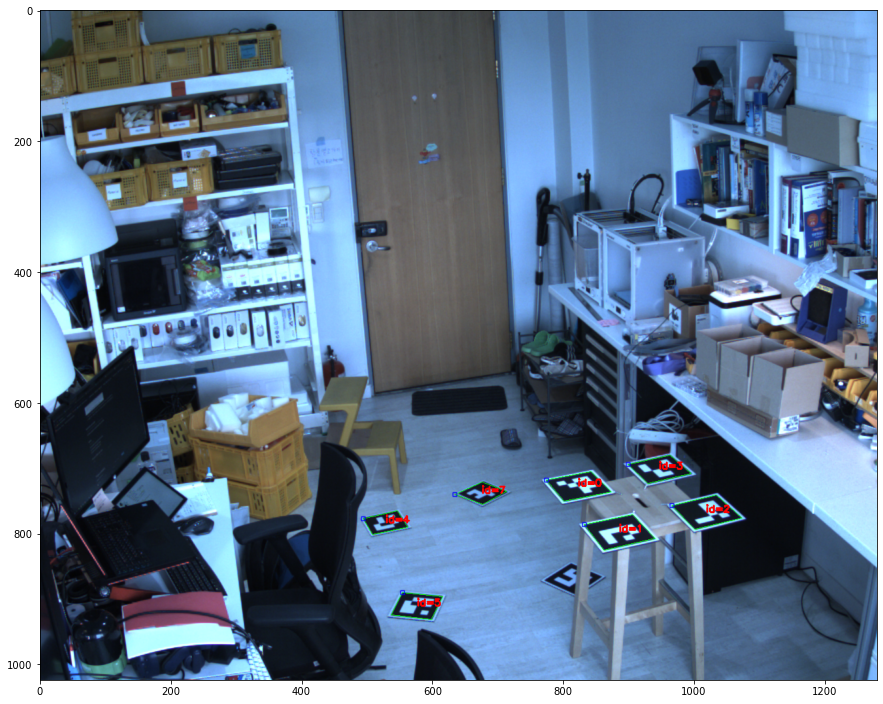

In [18]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
length_of_axis = 0.09
markerLength = 0.18

white_background  = np.full((1024, 1280, 3),255)
# white_background = (np.float32(white_background), cv2.COLOR_RGB2GRAY)


image_data = "./img/000000000021_rendered.png"
frame  = cv2.imread(image_data,cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)


frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# frame_markers = aruco.drawDetectedMarkers(white_background.copy(), corners, ids)

rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , mtx, dist)
# imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
# imaxis = aruco.drawDetectedMarkers(white_background, corners, ids)


for i in range(len(rvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)


# Marker data to dictionary
marker_dict = {}

for idx,marker_index in enumerate(ids):
    marker_index = marker_index[0]
    _vecs = {}
    _vecs["rvec"] = rvecs[idx][0]
    _vecs["tvec"] = tvecs[idx][0]
    _vecs["corner"] = corners[idx][0]
    marker_dict[marker_index] = _vecs
print("tvecs and rvecs for each marker\n")
# pp.pprint(marker_dict)
plt.figure()
plt.figure(figsize=(15,15))
plt.imshow(imaxis)
plt.imshow(frame_markers)

plt.show()

In [37]:
up_vector = upVectorFromDic(5,4,7)
print(up_vector)

[-0.06244402 -0.97513376 -0.21263794]


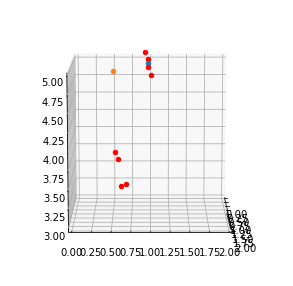

In [154]:
fig = plt.figure(figsize=(5,5))        
threedee = fig.add_subplot(1,1, 1,projection='3d')
threedee.set_xlim([0,2])
threedee.set_ylim([0,2])
threedee.set_zlim([3,5])
# plt3d.plot_surface(xx, yy, z)
for i in range(8):
    threedee.scatter(tvecs[i][0][0],tvecs[i][0][1],tvecs[i][0][2],color = "red")
    
threedee.scatter(center[0],center[1],center[2])
threedee.scatter(zaxis[0],zaxis[1],zaxis[2])

center = np.average(np.array([getPositionFromDic(4),getPositionFromDic(5),getPositionFromDic(6),getPositionFromDic(7)]),axis= 0)
zaxis = center + np.array(floor_up_vector_cross)/2

threedee.view_init(elev=10, azim=0)

plt.show()